In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pyarrow.compute as pc
from rdkit import Chem
from rdkit.Chem import AllChem
import multiprocessing as mp
import re
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
from xml.etree import ElementTree as ET
import numpy as np
from functools import partial
import svg_stack as ss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatch
from itertools import repeat



In [2]:
NB_CORES = 10
PATTERN =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
SMILES_REGEX = re.compile(PATTERN)

In [3]:
table = pq.read_table('../data/processed/compressed_whole_MOSES_ClearSMILES_results.parquet')

In [4]:
def get_canonical_SMILES(sanitized_smiles : str) -> str:
    """
    Take a sanitized SMILES and get the canonical SMILES out of it. achieved by generating 2D mol
    input: 
        sanitized_smiles (string), SMILES that has been sanitized by removing its explicit hydrogen + no charges 
    output: 
        canonical_smiles (string), canoncial SMILES generated using RDKIT algorithm 
    """
    ###  generate 2D structure from SMILES 
    mol= Chem.MolFromSmiles(sanitized_smiles)

    return Chem.MolToSmiles(mol)

In [5]:
def get_semantic_memmap(smiles :str,smiles_regex :re.compile) -> np.array: 
    """
    This function will generate a semantic memory map of a SMILES, i.e the number of semantic feature open for every token. 
    Semantic feature include  branches and  rings 
        smiles (string) : a valid SMILES 
        SMILES_REGEX (compiled regular expression): compiled regular expression used to tokenize SMILES
        bonds_set (set of strings): a set containing all the bonds tokens
    output :
        results_dict  (dict):   contains smiles, data augmentation and memory score
    """

    ### declare local variables
    tokens_list=smiles_regex.findall(smiles)
    mem_map= np.zeros(len(tokens_list),dtype=int)
    digit_set=set()

    ### iterate throught tokens 
    for i,token in enumerate(tokens_list):
        if token=="(":
            mem_map[i]+= 1
        elif token==")":
            mem_map[i]-=1
        elif token.isdigit():
            if token in digit_set:
                digit_set.remove(token)
                mem_map[i]-= 1
            else:
                digit_set.add(token)
                mem_map[i]+= 1


    
    return mem_map.cumsum()

def  memory_score(smiles : str, regex: re.compile) -> float:
    """
    This function will generate a memory score of a SMILES, i.e the number of semantic feature open for every token. 
    Semantic feature include  branches and  rings 
        smiles (string) : a valid SMILES 
        SMILES_REGEX (compiled regular expression): compiled regular expression used to tokenize SMILES
    output :
        memory_score (float): the memory score of the SMILES
    """
    return np.mean(get_semantic_memmap(smiles,regex))

def std_semantic_memmap(smiles :str,smiles_regex :re.compile) -> float:
    """
    This function will generate a semantic memory map of a SMILES, i.e the number of semantic feature open for every token.
    Semantic feature include  branches and  rings 
        smiles (string) : a valid SMILES 
        SMILES_REGEX (compiled regular expression): compiled regular expression used to tokenize SMILES
    output :    
        std_mem_map (float): the standard deviation of the memory map
    """
    return np.std(get_semantic_memmap(smiles,smiles_regex))

In [6]:
with mp.Pool(NB_CORES) as pool:
    results = pool.map(get_canonical_SMILES, table["SMILES"].to_pylist())
table=table.append_column('canonical_SMILES', pa.array(results))

In [7]:
def sample_clearsmiles(clearsmiles_list_string : str)->str:
    """
    function to split the undersocre separeted dumbsmiles list string and return the first element of that list, 
    works if there only one element in the list
    input: 
        dumsmiles_list_string (string), underscore separated dumbsmiles list string
    output:
        dumsmiles (string), the first element of the list
    """
    return clearsmiles_list_string.split('_')[0]

In [8]:
def std_sample_clearsmiles(clearsmiles_list_string : str, smiles_regex : re.compile) -> str:
    """
    function to split the undersocre separeted dumbsmiles list string and return the first element of that list,
    works if there only one element in the list
    input:
        clearsmiles_list_string (string), underscore separated dumbsmiles list string
    output: 
        dumsmiles (string), the first element of the list
    """

    # declare local variables
    min_std = None
    best_clearsmiles = None

    # split the string
    clearsmiles_list = clearsmiles_list_string.split('_')

    # iterate through the list
    for clearsmiles in clearsmiles_list:
        # get the std of the clearsmiles
        std = std_semantic_memmap(clearsmiles, smiles_regex)
        # if the std is smaller than the min_std or if min_std is None
        if min_std is None or std < min_std:
            min_std = std
            best_clearsmiles = clearsmiles

    return best_clearsmiles, min_std , len(clearsmiles_list)

In [9]:
with mp.Pool(NB_CORES) as pool:
    results = pool.map(sample_clearsmiles, table["ClearSMILES_set"].to_pylist())
table=table.append_column('sampled_ClearSMILES', pa.array(results))

In [10]:
with mp.Pool(NB_CORES) as pool:
    results = pool.map(partial(std_sample_clearsmiles, smiles_regex=SMILES_REGEX), table["ClearSMILES_set"].to_pylist())

In [11]:
best_clearsmiles, min_std, nb_clearsmiles = zip(*results)

In [12]:
table=table.append_column('best_ClearSMILES', pa.array(best_clearsmiles))
table=table.append_column('min_std', pa.array(min_std))
table=table.append_column('nb_ClearSMILES', pa.array(nb_clearsmiles))

In [13]:
# Create boolean masks for each condition
improved_mask = pc.not_equal(table["best_ClearSMILES"], table["sampled_ClearSMILES"])
equivalent_mask = pc.and_(pc.equal(table["best_ClearSMILES"], table["sampled_ClearSMILES"]), pc.greater(table["nb_ClearSMILES"], 1))
already_unique_mask = pc.equal(table["nb_ClearSMILES"], 1)

# Create the improvement_status column using the masks
improvement_status = pc.if_else(improved_mask, "improved",
                                pc.if_else(equivalent_mask, "equivalent", "already_unique"))

# Append the new column to the table
table = table.append_column('improvement_status', improvement_status)
# END: Add improvement_status column

In [14]:
count_df= pd.DataFrame(pc.value_counts(table["improvement_status"]).to_pylist())

In [15]:
count_df["normalized"]= count_df["counts"]/count_df["counts"].sum() * 100

In [16]:
count_df

,values,counts,normalized
0,improved,259423,13.393293
1,equivalent,1315668,67.924306
2,already_unique,361871,18.682401


In [17]:
part_func = partial(memory_score,regex=SMILES_REGEX)
with mp.Pool(NB_CORES) as pool:
    results = pool.map(part_func, table["canonical_SMILES"].to_pylist())
table=table.append_column('can_memory_score', pa.array(results))

In [18]:
table.to_pandas()

,nb_random,max_digit,lowest_mem_score,nb_unique_random_smiles,nb_lowest_max_digit_smiles,nb_equivalent_solution,ClearSMILES_set,random_gen_time,min_max_digit_time,mem_map_time,total_time,SMILES,SPLIT,canonical_SMILES,sampled_ClearSMILES,best_ClearSMILES,min_std,nb_ClearSMILES,improvement_status,can_memory_score
0,100000,1,0.906977,7614,5025,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F_FC...,6.809037,0.023423,0.175887,7.008428,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,train,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F,FC1=C(F)C(F)=CC=C1S(=O)(=O)NC1=CC(F)=CC=C1F,0.602860,2,improved,1.189189
1,100000,1,0.829268,2544,1656,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N_N#CC...,6.461382,0.007614,0.052121,6.521148,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,test,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N,0.620874,2,equivalent,2.000000
2,100000,1,0.853659,2544,1656,2,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F_FC1=...,6.471750,0.007562,0.052288,6.531633,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,train,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F,0.646226,2,equivalent,2.000000
3,100000,2,0.955556,4820,3614,1,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,7.824565,0.013055,0.124897,7.962536,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,train,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,0.594626,1,already_unique,1.282051
4,100000,1,0.857143,4463,2879,2,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F_FC1...,6.936087,0.013249,0.097328,7.046707,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,train,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC(OC)=CC=C1OC,0.600453,2,improved,2.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936957,100000,2,0.875000,2176,1688,1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,16.224227,0.010762,0.102354,16.337362,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,train,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,0.677772,1,already_unique,2.171429
1936958,100000,2,0.952381,4112,3256,3,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1_C1C...,15.889686,0.020518,0.196105,16.106328,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,train,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1,0.652919,3,equivalent,2.171429
1936959,100000,2,0.875000,2080,1360,1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,16.651164,0.009991,0.081478,16.742665,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,train,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,0.639824,1,already_unique,1.555556
1936960,100000,1,0.790698,2112,736,8,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1_C1...,15.300178,0.010769,0.045422,15.356399,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,test_scaffolds,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,0.552295,8,equivalent,1.583333


In [19]:
part_func = partial(std_semantic_memmap,smiles_regex=SMILES_REGEX)
with mp.Pool(NB_CORES) as pool:
    results = pool.map(part_func, table["canonical_SMILES"].to_pylist())
table=table.append_column('can_std_mem_map', pa.array(results))

In [20]:
part_func = partial(memory_score,regex=SMILES_REGEX)
with mp.Pool(NB_CORES) as pool:
    results = pool.map(part_func, table["sampled_ClearSMILES"].to_pylist())
table=table.append_column('clear_memory_score', pa.array(results))

In [21]:
part_func = partial(std_semantic_memmap,smiles_regex=SMILES_REGEX)
with mp.Pool(NB_CORES) as pool:
    results = pool.map(part_func, table["sampled_ClearSMILES"].to_pylist())
table=table.append_column('clear_std_mem_map', pa.array(results))

In [125]:
col_sel=['can','clear']
df_list=[]
for col in col_sel :
    augmentation_type= "ClearSMILES" if "clear" in col else "canonical_SMILES"
    df_list.append(pd.DataFrame(data=zip(
                                table[col+"_memory_score"].to_pylist(),
                                table[col+"_std_mem_map"].to_pylist(),
                                         [augmentation_type]*len(table)), 
                                columns=["memory_score","std_mem_map" ,'augmentation_type']))
df_list.append(
    pd.DataFrame(data=zip(
        table["can_memory_score"].to_pylist(),
        table["min_std"].to_pylist(),
        ["best_ClearSMILES"]*len(table)), 
        columns=["memory_score","std_mem_map" ,'augmentation_type'])
)
df= pd.concat(df_list)

In [126]:
df

,memory_score,std_mem_map,augmentation_type
0,1.189189,0.833029,canonical_SMILES
1,2.000000,1.171080,canonical_SMILES
2,2.000000,1.171080,canonical_SMILES
3,1.282051,0.875557,canonical_SMILES
4,2.026316,1.087896,canonical_SMILES
...,...,...,...
1936957,2.171429,0.677772,best_ClearSMILES
1936958,2.171429,0.652919,best_ClearSMILES
1936959,1.555556,0.639824,best_ClearSMILES
1936960,1.583333,0.552295,best_ClearSMILES


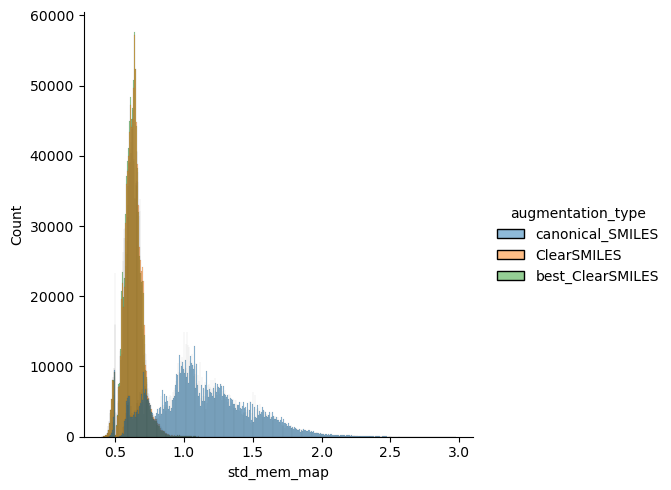

In [127]:
sns.displot(data=df, x="std_mem_map", hue="augmentation_type", fill=True)

In [25]:
df

,memory_score,std_mem_map,augmentation_type
0,1.189189,0.833029,canonical_SMILES
1,2.000000,1.171080,canonical_SMILES
2,2.000000,1.171080,canonical_SMILES
3,1.282051,0.875557,canonical_SMILES
4,2.026316,1.087896,canonical_SMILES
...,...,...,...
1936957,0.875000,0.677772,ClearSMILES
1936958,0.952381,0.652919,ClearSMILES
1936959,0.875000,0.639824,ClearSMILES
1936960,0.790698,0.552295,ClearSMILES


In [26]:
table.column_names

['nb_random',
 'max_digit',
 'lowest_mem_score',
 'nb_unique_random_smiles',
 'nb_lowest_max_digit_smiles',
 'nb_equivalent_solution',
 'ClearSMILES_set',
 'random_gen_time',
 'min_max_digit_time',
 'mem_map_time',
 'total_time',
 'SMILES',
 'SPLIT',
 'canonical_SMILES',
 'sampled_ClearSMILES',
 'best_ClearSMILES',
 'min_std',
 'nb_ClearSMILES',
 'improvement_status',
 'can_memory_score',
 'can_std_mem_map',
 'clear_memory_score',
 'clear_std_mem_map']

In [27]:
table=table.append_column('diff_mem_score',pc.subtract(table["can_memory_score"],table["clear_memory_score"]))

In [28]:
df=table["clear_memory_score"].to_pandas()

In [29]:
# Assuming 'table' is your PyArrow table
# Sort the table by 'diff_mem_score' in descending order
sorted_indices = pc.sort_indices(table, sort_keys=[('diff_mem_score', 'descending')])

# Select the top 10 indices
top_10_indices = sorted_indices[:10]

# Filter the table using the top 10 indices
filtered_table = table.take(top_10_indices)

# Display the result
subset=filtered_table.to_pandas()

In [30]:
subset

,nb_random,max_digit,lowest_mem_score,nb_unique_random_smiles,nb_lowest_max_digit_smiles,nb_equivalent_solution,ClearSMILES_set,random_gen_time,min_max_digit_time,mem_map_time,...,sampled_ClearSMILES,best_ClearSMILES,min_std,nb_ClearSMILES,improvement_status,can_memory_score,can_std_mem_map,clear_memory_score,clear_std_mem_map,diff_mem_score
0,100000,1,0.979592,2816,208,8,N1N=CC=C1C1=CC=C(C=C1)N1CCC(CC1)N1CC(C1)N1N=CC...,9.255124,0.007770,0.028001,...,N1N=CC=C1C1=CC=C(C=C1)N1CCC(CC1)N1CC(C1)N1N=CC=C1,N1N=CC=C1C1=CC=C(C=C1)N1CCC(CC1)N1CC(C1)N1N=CC=C1,0.622365,8,equivalent,4.844444,2.756451,0.979592,0.622365,3.864853
1,100000,1,1.000000,5760,448,8,N1=CC=CN1C1=CC=C(C=N1)C1=NOC(=N1)C1(CC1)C1=CC=...,9.264339,0.014758,0.015925,...,N1=CC=CN1C1=CC=C(C=N1)C1=NOC(=N1)C1(CC1)C1=CC=...,N1=CC=CN1C1=CC=C(C=N1)C1=NOC(=N1)C1(CC1)C1=CC=...,0.626224,8,equivalent,4.822222,2.807046,1.000000,0.626224,3.822222
2,100000,2,1.160000,11700,666,2,C1C2OCOC=2C=C2C=1N=C1N2N=C(N1)NCC1(CC1)C1C=CC=...,9.355698,0.022220,0.022784,...,C1C2OCOC=2C=C2C=1N=C1N2N=C(N1)NCC1(CC1)C1C=CC=...,C1C2OCOC=2C=C2C=1N=C1N2N=C(N1)NCC1(CC1)C1C=CC=...,0.674092,2,equivalent,4.913043,2.947557,1.160000,0.674092,3.753043
3,100000,1,0.909091,2560,200,2,C1CCC1C1=NN=C(O1)CN1CCCC(C1)C1=NOC(=N1)C1CC1_C...,9.542057,0.006877,0.007735,...,C1CCC1C1=NN=C(O1)CN1CCCC(C1)C1=NOC(=N1)C1CC1,C1CCC1C1=NN=C(O1)CN1CCCC(C1)C1=NOC(=N1)C1CC1,0.633109,2,equivalent,4.547619,2.574623,0.909091,0.633109,3.638528
4,100000,2,1.000000,4224,1576,2,C1CC1C1ON=C(N=1)CN1CCCN(CC1)C1=NC=NC2=C1CCC2_C...,9.906856,0.012445,0.059706,...,C1CC1C1ON=C(N=1)CN1CCCN(CC1)C1=NC=NC2=C1CCC2,C1CC1C1ON=C(N=1)CN1CCCN(CC1)C1=NC=NC2=C1CCC2,0.639602,2,equivalent,4.511628,2.644627,1.000000,0.639602,3.511628
5,100000,2,1.040816,4704,2196,8,C1=CN=CC=C1C1(CC1)CNC1C2CCCC=2N=C(N=1)C1C=NC=C...,8.702544,0.010317,0.071610,...,C1=CN=CC=C1C1(CC1)CNC1C2CCCC=2N=C(N=1)C1C=NC=CC=1,C1=CN=CC=C1C1(CC1)CNC1C2CCCC=2N=C(N=1)C1C=NC=CC=1,0.668815,8,equivalent,4.533333,2.840970,1.040816,0.668815,3.492517
6,100000,2,1.000000,8698,3094,10,C1C=C2OCOC2=CC=1CN1CCC(C1)C1=NN=C(O1)C1OC=CC=1...,8.016989,0.017844,0.097510,...,C1C=C2OCOC2=CC=1CN1CCC(C1)C1=NN=C(O1)C1OC=CC=1,O1COC2C1=CC=C(C=2)CN1CCC(C1)C1=NN=C(O1)C1=CC=CO1,0.612372,10,improved,4.454545,2.571297,1.000000,0.625543,3.454545
7,100000,2,1.021277,4160,1476,2,O1CCC2C1=CC=C(C=2)CN1CC(C1)C1ON=C(N=1)C1=CC=CS...,9.863764,0.010972,0.065675,...,O1CCC2C1=CC=C(C=2)CN1CC(C1)C1ON=C(N=1)C1=CC=CS1,O1CCC2C1=CC=C(C=2)CN1CC(C1)C1ON=C(N=1)C1=CC=CS1,0.635455,2,equivalent,4.441860,2.599663,1.021277,0.635455,3.420584
8,100000,1,0.979167,2688,200,4,N1=CC=CN1C1N=CN=C(C=1)N1CCC(CC1)N1N=NC(=C1)C1C...,8.252239,0.005687,0.006762,...,N1=CC=CN1C1N=CN=C(C=1)N1CCC(CC1)N1N=NC(=C1)C1CC1,N1=CC=CN1C1N=CN=C(C=1)N1CCC(CC1)N1N=NC(=C1)C1CC1,0.628808,4,equivalent,4.386364,2.604331,0.979167,0.628808,3.407197
9,100000,1,0.980392,5376,400,4,N1=CC=CC=C1C1ON=C(N=1)C1=CC=CC(=C1)C1=CSC(=N1)...,8.170784,0.011968,0.013446,...,N1=CC=CC=C1C1ON=C(N=1)C1=CC=CC(=C1)C1=CSC(=N1)...,C1CC1C1SC=C(N=1)C1C=CC=C(C=1)C1=NOC(=N1)C1N=CC...,0.610053,4,improved,4.369565,2.598986,0.980392,0.610053,3.389173


In [31]:
def map_atoms_to_color(tokens : list[str],mem_map : np.array ,color_palette: list[tuple],can_idces : list[int]) -> dict:
    """
    Map a score to a color from a color palette.

    Args:
        tokens (list of str): List of tokens.
        memmap (np.array): Array of scores.
        color_palette (list of tuple): List of RGB tuples for the color palette.
        can_indices (list of int): List of  canonical atoms indices.

    Returns:
        dict: Dictionary mapping can atom indices to colors.
    """
    # declare local variable
    atoms_counter= 0
    can_atoms_color_dict={}

    # check if max score is not bigger then color palette
    assert max(mem_map) < len(color_palette), "The maximum score is bigger than the color palette."

    ### iterate through SMILES to map atoms to their color
    for i,token in enumerate(tokens) : 
        ### assume that an atom token is always comprised of uniquely letter or is between bracket
        if token.isalpha() or ("[" == token[0] and "]"==token[-1]):
            atom_color=color_palette[mem_map[i]]
            can_atom_idx = can_idces[atoms_counter]
            can_atoms_color_dict[can_atom_idx]= atom_color
            atoms_counter+=1
    
    return can_atoms_color_dict

def memory_score_view_mol(smiles_list: list  ,
                          regex: re.compile,
                          color_palette : list,
                          atom_radii : float,
                          display_atom_idx : bool,
                          fontscale : float) -> str:
    """ Use RDKit to draw a molecule with a color code based on the memory score of each atom.

    Args:
        smiles (str): a VALID SMILES 
        regex (re.compile):  the regular expression used to tokenize smiles
        color_palette (list): a color palette to higlight molecules, should be a list of tuple
        atom_radii (float): the radii to higligh atomms 
        display_atom_idx (bool): a boolean to display atom index

    Returns:
        str: a SVG string of the molecule
    """

    ### declare local variables
    can_atoms_color_dict={}
    bonds_color_dict={}
    results=[]

    # compute mol from template
    template_mol = Chem.MolFromSmiles(smiles_list[0])
    can_idces_dict= { can_idx : i for i,can_idx in
        enumerate(Chem.CanonicalRankAtoms(template_mol))}


    for smiles in smiles_list:
        mem_map=get_semantic_memmap(smiles,smiles_regex=regex)

        ### tokenize smiles
        tokens=regex.findall(smiles)

        ### get canonical atom indices
        mol=Chem.MolFromSmiles(smiles)
        temp_can_idces=Chem.CanonicalRankAtoms(mol)

        ### map atoms to color
        can_atoms_color_dict= map_atoms_to_color(tokens,
                                             mem_map,
                                             color_palette,
                                             temp_can_idces
                                             )
        
        ### remap  template mol atom labels
        if display_atom_idx:
            for atom in mol.GetAtoms():
                can_atom_idx= temp_can_idces[atom.GetIdx()]
                template_atom= template_mol.GetAtomWithIdx(can_idces_dict[can_atom_idx])
                template_atom.SetAtomMapNum(atom.GetIdx()+1)

        ### iterate through bonds to populate bond highligth color
        for bond in mol.GetBonds():

            # get bond idx of template mol
            atoms_idx_pair= [bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()]
            atoms_idx_pair = [temp_can_idces[atom_idx] for atom_idx in atoms_idx_pair]
            bond_idx= template_mol.GetBondBetweenAtoms(can_idces_dict[atoms_idx_pair[0]],
                                              can_idces_dict[atoms_idx_pair[1]]
                                              ).GetIdx()
            
            ### get color of atoms   
            begin_atom_color= can_atoms_color_dict[atoms_idx_pair[0]]
            end_atom_color=can_atoms_color_dict[atoms_idx_pair[1]]

            ### assign color(s) to bond
            if list(can_atoms_color_dict.values()).index(begin_atom_color)>list(can_atoms_color_dict.values()).index(end_atom_color):
                bonds_color_dict[bond_idx]= [begin_atom_color]
            else:
                bonds_color_dict[bond_idx]= [end_atom_color]
            # bonds_color_dict[bond_idx]= [begin_atom_color,end_atom_color]



        ### make the image 
        d2d = rdMolDraw2D.MolDraw2DSVG(500,200)
        if display_atom_idx:
            d2d.drawOptions().baseFontSize = fontscale

        d2d.DrawMoleculeWithHighlights(template_mol,
                                       "", # no caption
                                       {can_idces_dict[can_atom_idx]: [color] 
                                        for can_atom_idx, color in can_atoms_color_dict.items()
                                       },
                                       bonds_color_dict,
                                       dict(zip(range(mol.GetNumAtoms()),repeat(atom_radii))),
                                       {}
                                       )
        d2d.FinishDrawing()
        results.append(d2d.GetDrawingText())

    return results

def get_color_code(rgb : tuple) -> str:
    """
    Convert an RGB tuple to an ANSI escape code for colored output.
    Args:
        rgb (tuple): Tuple of RGB values (0-1).
    Returns:
        str: ANSI escape code for colored output.
    """
    r, g, b = [int(x * 255) for x in rgb[:3]]
    return f'\x1b[38;2;{r};{g};{b}m'

def color_string_by_semantic_map(token_list : list[str],
                                 semantic_map : np.array,
                                 color_palette : list[tuple],
                                 max_token : int)-> str:
    """ Colorize a string based on a semantic map using a color palette.

    Args:
        token_list (list[str]): List of tokens to colorize.
        semantic_map (np.array): Semantic map for each token.
        color_palette (list[tuple]): List of RGB tuples for the color palette.
        max_token (int): Maximum token length.

    Returns:
        str: Colorized string with ANSI escape codes.
    """
    # declare local variable
    colored_string_list = []

    # iterate through tokens and semantic map
    for token, score in zip(token_list, semantic_map):
        color_code = get_color_code(color_palette[score % len(color_palette)])
        # Add ANSI escape code to colorize the token
        colored_token = f"{color_code}{token.center(max_token + 2)}\x1b[0m"
        colored_string_list.append(colored_token)  
    
    return "|".join(colored_string_list)



def rgba_to_hex(rgba_str):
    # Extract the RGBA values using regex
    match = re.match(r'rgba\((\d+), (\d+), (\d+), ([0-9.]+)\)', rgba_str)
    if not match:
        raise ValueError("Invalid RGBA format")
    
    r, g, b, a = map(float, match.groups())
    
    # Convert RGBA to hexadecimal
    hex_color = f'#{int(r):02x}{int(g):02x}{int(b):02x}{int(a * 255):02x}'
    
    return hex_color

def rgba_to_rgb_tuple(rgba_str):
    # Extract the RGBA values using regex
    match = re.match(r'rgba\((\d+), (\d+), (\d+), ([0-9.]+)\)', rgba_str)
    if not match:
        raise ValueError("Invalid RGBA format")
    
    r, g, b, a = map(float, match.groups())
    
    # Normalize RGB values to the range [0, 1]
    rgb_tuple = (r / 255, g / 255, b / 255)
    
    return rgb_tuple

def show_color_palette(hex_colors):
    
    
    fig = plt.figure(figsize=[9, 5])
    ax = fig.add_axes([0, 0, 1, 1])
    
    n_colors = len(hex_colors)
    n_rows = n_colors // 3 + 1
    
    for j, hex_color in enumerate(hex_colors):
        col_shift = (j // n_rows) * 3
        y_pos = j % n_rows
        
        rgba = mcolors.to_rgba(hex_color)
        luma = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        text_color = 'k' if luma > 0.5 else 'w'
        
        ax.add_patch(mpatch.Rectangle((0 + col_shift, y_pos), 1, 1, color=hex_color))
        ax.text(0.5 + col_shift, y_pos + .7, hex_color,
                color=text_color, ha='center', fontsize=10, weight='bold')
    
    ax.set_xlim(0, 3 * (n_colors // n_rows + 1))
    ax.set_ylim(n_rows, -1)
    ax.axis('off')
    
    plt.show()
def save_svg_to_file(svg_string: str, file_path: str) -> None:
    """
    Save an SVG string to a file.

    Args:
        svg_string (str): The SVG content as a string.
        file_path (str): The path to the file where the SVG should be saved.
    """
    with open(file_path, 'w') as file:
        file.write(svg_string)

In [109]:
color_palette=[
               {"value":"rgba(158, 1, 66, 1)"},
               {"value":"rgba(213, 62, 79, 1)"},
               {"value":"rgba(244, 109, 67, 1)"},
               {"value":"rgba(253, 174, 97, 1)"},
               {"value":"rgba(254, 224, 139, 1)"},
               {"value":"rgba(230, 245, 152, 1)"},
               {"value":"rgba(171, 221, 164, 1)"},
               {"value":"rgba(102, 194, 165, 1)"},
               {"value":"rgba(50, 136, 189, 1)"},
               {"value":"rgba(94, 79, 162, 1)"},
]
color_palette.reverse()

hex_palette=[rgba_to_hex(color["value"]) for color in color_palette]



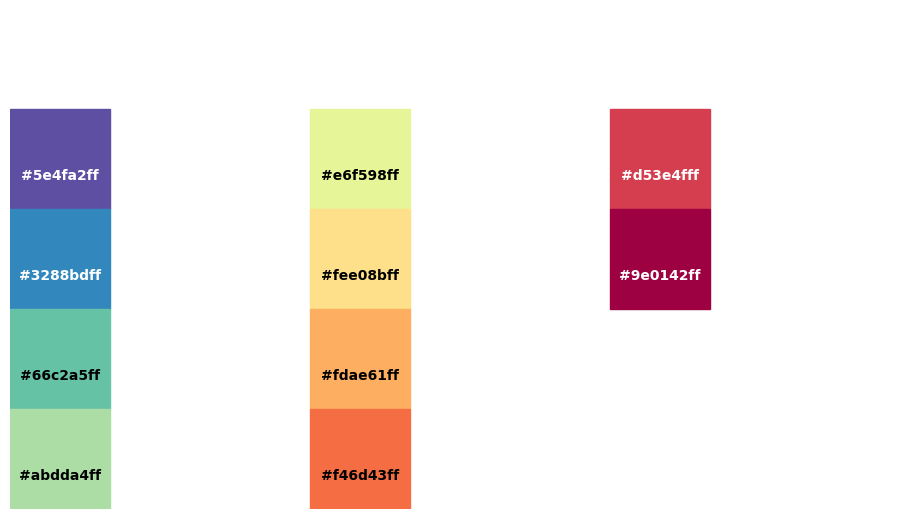

In [110]:
show_color_palette(hex_palette)

In [111]:
rgb01_palette=[rgba_to_rgb_tuple(color["value"]) for color in color_palette]
rgb01_palette= rgb01_palette+[(.3,.3,.3)]

In [112]:
smiles_list=zip(subset["canonical_SMILES"], subset["sampled_ClearSMILES"])

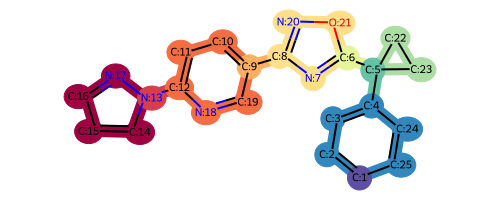

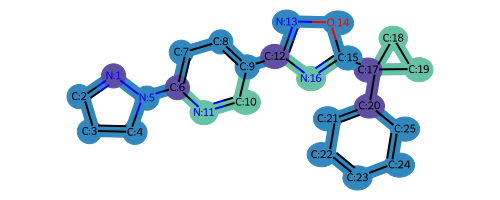

In [114]:
smiles_duet= next(smiles_list)
svg_list= memory_score_view_mol(smiles_duet,
                                SMILES_REGEX,
                                rgb01_palette,
                                0.5,
                                True,
                                0.45)
for i,svg_str in enumerate(svg_list):
    display(SVG(svg_str))
    save_svg_to_file(svg_str, f"molecule_{i}.svg")

In [115]:
print(smiles_duet[1])

N1=CC=CN1C1=CC=C(C=N1)C1=NOC(=N1)C1(CC1)C1=CC=CC=C1


In [116]:
def concatenate_svgs_horizontally(svg_file_paths, output_file_path):
    """
    Concatenate SVG files horizontally and save to a file.

    Args:
        svg_file_paths (list of str): List of paths to the SVG files to concatenate.
        output_file_path (str): The path to the output file where the concatenated SVG should be saved.
    """
    # Create a horizontal layout
    layout = ss.HBoxLayout()

    # Add each SVG file to the layout
    for svg_file_path in svg_file_paths:
        layout.addSVG(svg_file_path)

    # Save the concatenated SVG to the output file
    with open(output_file_path, 'w') as output_file:
        output_file.write(layout.render())

def centering_token(token : str, max_token : int) -> str:
    """
    Center a token in a string.

    Args:
        token (str): The token to center.
        max_token (int): The maximum length of the token.

    Returns:
        str: The centered token.
    """
    return token.center(max_token)


In [142]:
def generate_svg_caption(token_with_colors, score_with_color, font_family="Arial", font_size=16, data_augmentation="ClearSMILES"):
    svg_string = '<svg width="1370" height="100" xmlns="http://www.w3.org/2000/svg">\n'
    x_position = 10  # Initial x position for the first word
    y_position = 60  # y position for all words
    y_offset = -30
    svg_string += f'  <text x="{x_position}" y="{y_position + y_offset}" font-family="{font_family}" font-size="{font_size}" fill="black">{data_augmentation}</text>\n'
    

    for i, (word, color) in enumerate(token_with_colors):
        word_width = len(word) * (font_size * 0.6)  # Estimate the width of the word
        rect_height = font_size * 1.2  # Height of the rectangle
        rect_y_position = y_position - rect_height + 5  # Adjust y position for the rectangle

        # Draw the rectangle behind the text
        svg_string += f'  <rect x="{x_position}" y="{rect_y_position}" width="{word_width}" height="{rect_height}" fill="{color}" />\n'

        svg_string += f'  <text x="{x_position}" y="{y_position}" font-family="{font_family}" font-size="{font_size}" fill="black">{word}</text>\n'

        
        # Adjust x position for the next word with additional spacing
        x_position += len(word) * (font_size * 0.4) +5 if i != 0 else len(word) * (font_size * 0.4) +5

        if i < len(token_with_colors) - 1:  # Add separator if not the last word
            svg_string += f'  <text x="{x_position}" y="{y_position}" font-family="{font_family}" font-size="{font_size}" fill="black">|</text>\n'
            x_position += font_size * 0.6  # Adjust x position for the separator
        
    # update starting position
    x_position=10
    y_position+= 25

    for i, (word, color) in enumerate(score_with_color):
        word_width = len(word) * (font_size * 0.6)  # Estimate the width of the word
        rect_height = font_size * 1.2  # Height of the rectangle
        rect_y_position = y_position - rect_height + 5  # Adjust y position for the rectangle

        # Draw the rectangle behind the text
        svg_string += f'  <rect x="{x_position}" y="{rect_y_position}" width="{word_width}" height="{rect_height}" fill="{color}" />\n'

        svg_string += f'  <text x="{x_position}" y="{y_position}" font-family="{font_family}" font-size="{font_size}" fill="black">{word}</text>\n'

        # Adjust x position for the next word with additional spacing
        x_position += len(word) * (font_size * 0.4) +5 if i != 0 else len(word) * (font_size * 0.4) +5
        
        if i < len(score_with_color) - 1:  # Add separator if not the last word
            svg_string += f'  <text x="{x_position}" y="{y_position}" font-family="{font_family}" font-size="{font_size}" fill="black">|</text>\n'
            x_position += font_size * 0.6  # Adjust x position for the separator

    svg_string += '</svg>'
    return svg_string

In [135]:
def process_smiles(smiles, smiles_regex, hex_palette, font_size=16, data_augmentation="ClearSMILES"):

    # declare local variable 
    colored_tokens = [("smiles: ", "white")]
    colored_scores = [("score:  ", "white")]
    # Split the SMILES string into individual tokens
    tokens = smiles_regex.findall(smiles)

    memory_map= get_semantic_memmap(smiles,smiles_regex)

    # Find the maximum token length
    max_token = max(map(len, tokens))

    # Center the token in the string
    centered_token = partial(centering_token, max_token=max_token)

    # Map the tokens to colors
    for token, score in zip(tokens, memory_map):
        color = hex_palette[score]
        colored_tokens.append((centered_token(token), color))
        colored_scores.append((centered_token(str(score)), color))
        
    # Generate the SVG caption
    svg_caption = generate_svg_caption(colored_tokens,colored_scores ,font_size=font_size, data_augmentation=data_augmentation)

    return svg_caption

In [119]:
hex_palette

['#5e4fa2ff',
 '#3288bdff',
 '#66c2a5ff',
 '#abdda4ff',
 '#e6f598ff',
 '#fee08bff',
 '#fdae61ff',
 '#f46d43ff',
 '#d53e4fff',
 '#9e0142ff']

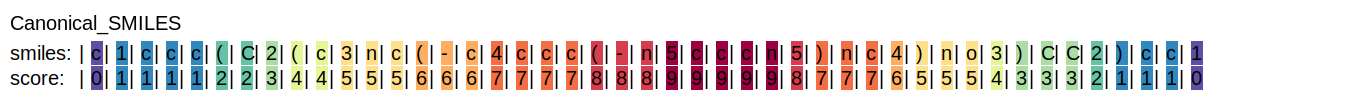

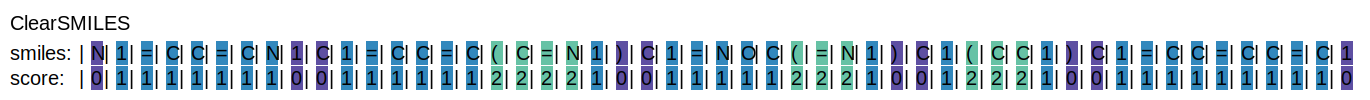

In [143]:
svg_string=process_smiles(smiles_duet[0], SMILES_REGEX, hex_palette, font_size=20, data_augmentation="Canonical_SMILES")
display(SVG(svg_string))
save_svg_to_file(svg_string, "can_caption.svg")
svg_string=process_smiles(smiles_duet[1], SMILES_REGEX, hex_palette, font_size=20, data_augmentation="ClearSMILES")
display(SVG(svg_string))
save_svg_to_file(svg_string, "clear_caption.svg")

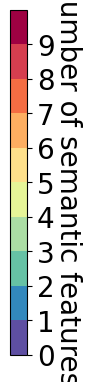

In [168]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def create_vertical_color_bar(hex_palette , output_file_path):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(2, 6))

    # Create a colormap from the hex palette
    cmap = mcolors.ListedColormap(hex_palette)

    # Create a norm object to map data values to the colormap
    norm = mcolors.Normalize(vmin=0, vmax=len(hex_palette))

    # Create a color bar
    color_bar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=norm),
        ax=ax,
        ticks=np.linspace(0, len(hex_palette), len(hex_palette)),
        orientation='vertical'
    )

    # Set the ticks and labels
    color_bar.set_ticks(np.arange(len(hex_palette)))
    color_bar.set_ticklabels([f'{i}' for i in range(len(hex_palette))],fontsize=20)

    # Remove the axis
    ax.remove()

    # Add a vertical caption
    color_bar.ax.set_ylabel('Number of semantic features', rotation=270, labelpad=20, fontsize=20)

    # Save the color bar as an SVG file
    plt.tight_layout()
    plt.savefig(output_file_path, format="svg")

    # Display the color bar
    plt.show()


create_vertical_color_bar(hex_palette, "cbar.svg")

In [47]:
import glob

In [166]:
def concatenate_svgs(svg_file_paths, cbar_path, output_file_path):
    """
    Concatenate SVG files horizontally and save to a file.

    Args:
        svg_file_paths (list of str): List of paths to the SVG files to concatenate.
        output_file_path (str): The path to the output file where the concatenated SVG should be saved.
    """
    doc = ss.Document()

    # Create a horizontal layout
    layout = ss.HBoxLayout()

    # Add each SVG file to the layout
    for svg_file_path in svg_file_paths:
        layout.addSVG(svg_file_path, alignment=ss.AlignTop|ss.AlignHCenter)
    
    # Create a vertical layout
    layout2=ss.VBoxLayout()
    layout2.addSVG(output_file_path)
    layout2.addSVG(cbar_path, alignment=ss.AlignCenter)

    layout.addLayout(layout2)
    doc.setLayout(layout)

    doc.save(output_file_path)
    
    
    


In [167]:
concatenate_svgs_horizontally(['molecule_0.svg',
                               'can_caption.svg',
                               'molecule_1.svg',
                               'clear_caption.svg',
 ], "cbar.svg","can_concatenated.svg")